# Resultados obtenidos del análisis de correspondencia múltiple


*   Instalación e importacion
* MCA basado en relacion
  - Estandarizado por num. de noticias
  - Estandarizado Max-Min

## Librerias

In [1]:
!pip install "pandas<2.0.0"
!pip install kaleido
!pip install prince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 13.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 4.8 MB/s eta 0:00:00


In [27]:
import string

In [2]:
import time
import pickle
import prince
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.colors
import matplotlib
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
#Montamos google drive para acceder a los archivos de nuestro dirve
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Funciones

In [5]:
path = '/content/drive/My Drive/Tesis/datos_tesis/Resultados/'

In [6]:
def config_fig(tx,ty,nx=10,ny=10):
  fig.update_xaxes(visible=True, fixedrange=False)
  fig.update_yaxes(visible=True, fixedrange=False)

  fig.update_layout(
      title="",
      yaxis_title=tx,
      xaxis_title=ty,
      legend_title="",
      title_font_color="red",
      legend_title_font_color="green",
      xaxis=dict(showgrid=False,showline=True,showticklabels=True,linewidth=3,nticks=nx,
          linecolor='rgb(204, 204, 204)',ticks='outside',
          tickfont=dict(family='Arial',size=15,color='rgb(82, 82, 82)',),
          titlefont=dict(family='Arial',size=18,color='black',)
          ),
      yaxis=dict(showgrid=True,showline=False,showticklabels=True, linewidth=2,nticks=ny,exponentformat = 'none',
          linecolor='rgb(204, 204, 204)',ticks='outside',
          tickfont=dict(family='Arial',size=15,color='rgb(82, 82, 82)'),
          titlefont=dict(family='Arial',size=18,color='black',)
                ),
      width=1200,
      height=400,
      margin=dict(l=10,r=10,t=10,b=10),
      showlegend=False,
      plot_bgcolor='white')

In [7]:
def Hurst_kweek(k_vecinos):
  s = 1/(np.exp(1)*((k_vecinos+10)**(1/3)))
  fig.add_trace(go.Scatter(x = ipc_return.index,y = H_matrix[k_vecinos,:], mode='lines',
        name='Hurst',line=dict(color='orange', width=2), showlegend=False))
  config_fig("Exponente de Hurst local","Fecha")
  indx = H_matrix[k_vecinos,:]<0.5-s
  fig.add_trace(go.Scatter(x = ipc_return.index[indx],y = H_matrix[k_vecinos,:][indx], mode='markers',marker_size=10,
          name='Anti-persistencia',line=dict(color='red', width=2)))

  indx = (H_matrix[k_vecinos,:]<0.5+s)&(H_matrix[k_vecinos,:]>0.5-s)
  fig.add_trace(go.Scatter(x = ipc_return.index[indx],y = H_matrix[k_vecinos,:][indx], mode='markers',marker_size=7,
          name='Eficiencia',line=dict(color='blue', width=1)))

  indx = H_matrix[k_vecinos,:]>0.5+s
  fig.add_trace(go.Scatter(x = ipc_return.index[indx],y = H_matrix[k_vecinos,:][indx], mode='markers',marker_size=10,
          name='Persistencia',line=dict(color='green', width=2)))

  fig.add_trace(go.Scatter(x = ipc_return.index,y = np.repeat(0.5+s,len(ipc_return)), mode='lines',
        name='',line=dict(color='blue', width=1, dash='dash'), showlegend=False))
  fig.add_trace(go.Scatter(x = ipc_return.index,y = np.repeat(0.5-s,len(ipc_return)), mode='lines',
        name='',line=dict(color='blue', width=1, dash='dash'), showlegend=False))

In [8]:
def listAlphabet():
  return list(string.ascii_uppercase)

In [9]:
def Create_Indices(Type_indices = 'mean',norm_indices='ts'):

    with open(path+ "Index_"+norm_indices+'_'+Type_indices+".pickle", "rb") as fp:
          ts_index = pickle.load(fp)

    return ts_index

In [10]:
def MCA_score(type_token,type_size,k_vecinos):
      indices = Create_Indices(type_token,type_size)
      time_index = indices.resample('W').count().index
      lv_val = [-0.001, 0.25, 0.5, 1.0001]
      lv_name = ['Bajo','Medio','Alto']
      cl_ax = ['red','orange','green']
      s = 1/(np.exp(1)*((k_vecinos+10)**(1/3)))
      bd_mca = pd.concat([pd.Series(np.array(pd.cut(H_matrix[k_vecinos,:], labels=['A.P','E','P'],
                                            bins=[np.min(H_matrix), 0.5-s, 0.5+s, np.max(H_matrix)])))]+
                [pd.Series(np.array(pd.cut(np.array(indices)[:-1,ts],lv_val,
                                          labels= lv_name ))) for ts in range(np.array(indices).shape[1])], axis=1)

      names = list(listAlphabet()[:len(indices.columns)])
      bd_mca.columns =  ['Hurst']+list(listAlphabet()[:len(indices.columns)])
      #names = []
      #for i in indices.columns:
      #  names.append(i.replace('3', '4').replace('2', '3').replace('1', '2').replace('0', '1'))

      #bd_mca.columns =  ['Hurst']+names
      Z = pd.get_dummies(bd_mca)
      ca_m = ca.fit(Z)

      tb_col = ['black','gray','brown','palegreen','teal','turquoise','yellow','purple','magenta','pink']
                #2013     2014      2015          2017
      df = pd.DataFrame(ca_m.row_coordinates(Z).values)
      df.columns= ['x','y','z']
      df['year'] = list(time_index[:-1].year)
      df['color'] = pd.Series(tb_col)[(df['year']-2013).values].values
      dc = pd.DataFrame(ca_m.column_coordinates(Z))
      dc.columns= ['x','y','z']
      dc['color'] = ['blue','blue','blue']+['green' if 'A.I' in name else 'red' for name in list(Z.columns[3:])]
      dc['indicador'] = dc.index

      df = df.astype({"year": str})
      df = pd.DataFrame(ca_m.row_coordinates(Z).values)
      df.columns= ['x','y','z']
      df['year'] = list(time_index[:-1].year)
      df['color'] = pd.Series(tb_col)[(df['year']-2013).values].values
      df = df.astype({"year": str})

      return dc,df

In [11]:
def MCA_plot(score_type,dc,df):

  lv_name = ['Bajo','Medio','Alto']
  cl_ax = ['red','orange','green']
  if score_type == 'col':
    fig.add_trace(go.Scatter(
              legendrank=2,
              legend="legend1",
              x=dc[dim[0]][:3],
              y=dc[dim[1]][:3],
              mode="text",
              name="Exp. Hurst",
              text=["P-", "EMH", "P+"],
              textposition="bottom center",
            textfont={"color": 'blue',"size": 20}
                ))

    k=0
    for ax in lv_name:
              ax_ = [True if ax in name else False for name in list(dc.index[3:])]
              fig.add_trace(go.Scatter(
                  legendrank=1,
                  legend="legend1",
                  x=dc[dim[0]][3:][ax_],
                  y=dc[dim[1]][3:][ax_],
                  mode="text",
                  name="Nivel: "+ax,
                  text=[ax_l.replace('_'+ax,'') for ax_l in list(dc.index[3:][ax_])],
                  textposition="bottom center",
                  marker_symbol = 'diamond',
                  marker_size=10,
                  marker={"color":cl_ax[k]},
                  textfont={"color":cl_ax[k],"size": 18}
              ))
              k=k+1
    fig.update_layout(legend1=dict(orientation="h",entrywidth=150,xanchor="center",x=0.5,
                                   itemsizing = 'constant',title = 'Indicadores',
                                font=dict(size=18,color="black"),))

  else:
      for year in range(2013,2023):
          dataset_by_year = df[df['year']==str(year)]
          fig.add_trace(go.Scatter(
                legend="legend2",
                x=dataset_by_year[dim[0]],
                y=dataset_by_year[dim[1]],
                mode="markers",
                name=str(year),
                marker={"color":dataset_by_year['color'],'size':8},
                text=dataset_by_year['year'],
                textposition="bottom center",
                textfont={"color":dataset_by_year['color'],"size": 9}
            ))
      fig.update_layout(legend2=dict(orientation="v",yanchor="middle",y=0.5,bgcolor='white',
                                    itemsizing = 'constant',
                                     title ='Semanas',
                                    font=dict(size=18,color="black"),))

  fig.update_layout(showlegend=True,template='plotly_white', title="MCA: "+str(10+k_vecinos)+" semanas",
          xaxis=dict(showgrid=True,showline=False,showticklabels=True,linewidth=3,
          linecolor='rgb(204, 204, 204)',ticks='outside',
          tickfont=dict(family='Arial',size=15,color='rgb(82, 82, 82)',),
          ),
      yaxis=dict(showgrid=True,showline=False,showticklabels=True, linewidth=2,nticks=10,exponentformat = 'none',
          linecolor='rgb(204, 204, 204)',ticks='outside',
          tickfont=dict(family='Arial',size=15,color='rgb(82, 82, 82)'),
          titlefont=dict(family='Arial',size=20,color='blue'),
                ),)

# Analisis de correspondencia multiple

In [59]:
ca = prince.CA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=20
)

In [60]:
with open(path+'Serie_IPC_return'+'.pickle', "rb") as fp:
    ipc_return = pickle.load(fp)

## TS

In [61]:
with open(path+ "Matrix_hurst.pickle", "rb") as fp:
    H_matrix = pickle.load(fp)
with open(path+ "Matrix_ts_mean.pickle", "rb") as fp:
    Ts_ax = pickle.load(fp)
with open(path+ "Index_ts_mean.pickle", "rb") as fp:
    Index_ts = pickle.load(fp)

M_coef_1 = Ts_ax[0]
M_coef_2 = Ts_ax[1]
M_coef_3 = Ts_ax[2]

In [62]:
type_token = 'mean'
type_size = 'ts'
dim = ['x','y']

In [63]:
col_names = []
for i in Index_ts.columns:
  col_names.append(i.replace('3', '4').replace('2', '3').replace('1', '2').replace('0', '1'))

### DTW

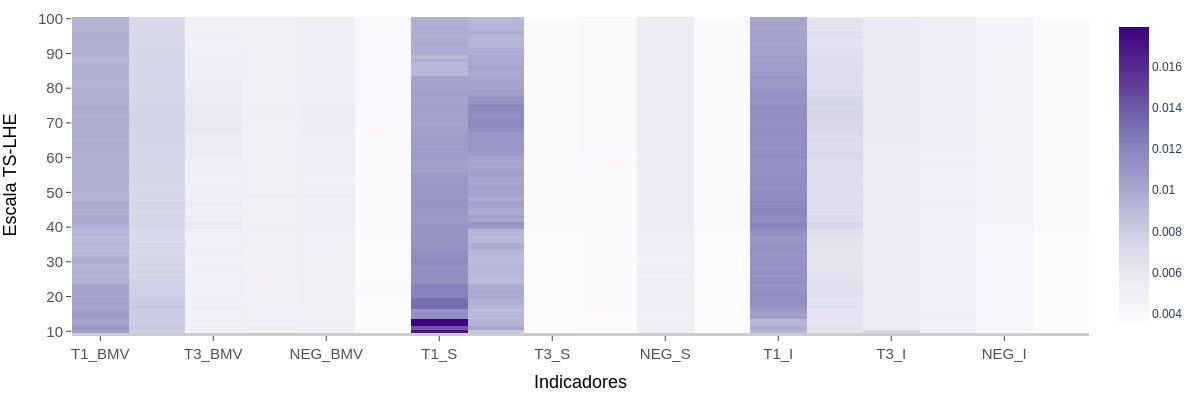

In [64]:
fig = px.imshow(M_coef_1,x=col_names,color_continuous_scale='Purples', origin='lower',
                y=list(np.arange(10,10+H_matrix.shape[0])))
config_fig('Escala TS-LHE','Indicadores')
fig.show(renderer="png")

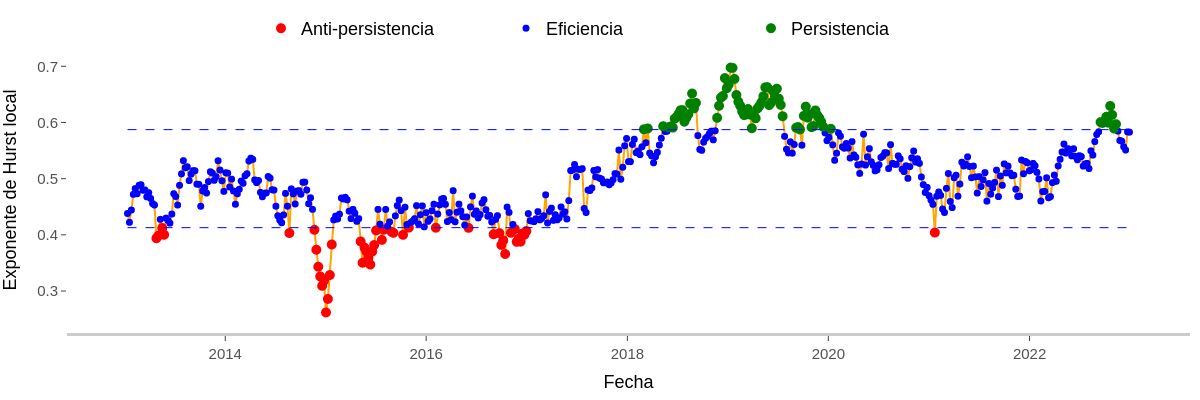

In [65]:
fig = go.Figure()
n = np.argmax(np.mean(M_coef_1,axis=1))
Hurst_kweek(n)

fig.update_layout(legend=dict(orientation="h",entrywidth=200,yanchor="bottom",y=1.0, xanchor="center",x=0.5,
                                font=dict(size=18,color="black"),))
fig.update_layout(showlegend=True)
fig.show(renderer="png")

In [66]:
k_vecinos = np.argmax(np.mean(M_coef_1,axis=1))
dc, df = MCA_score(type_token,type_size,k_vecinos)

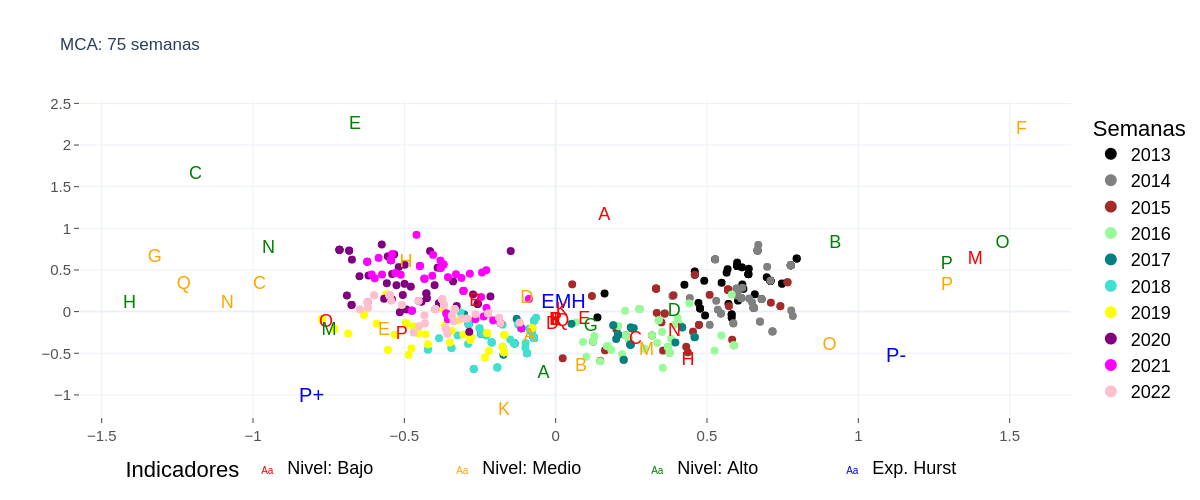

In [67]:
fig = go.Figure()
MCA_plot('row',dc,df)
MCA_plot('col',dc,df)

fig.update_layout(template='plotly_white', title="MCA: "+str(10+k_vecinos)+" semanas")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

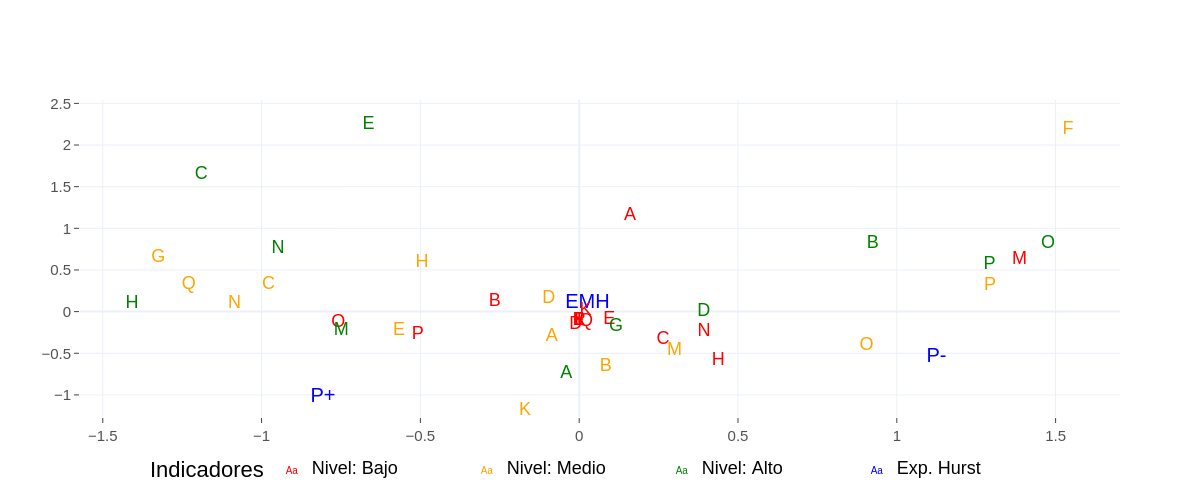

In [68]:
fig = go.Figure()
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title="")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

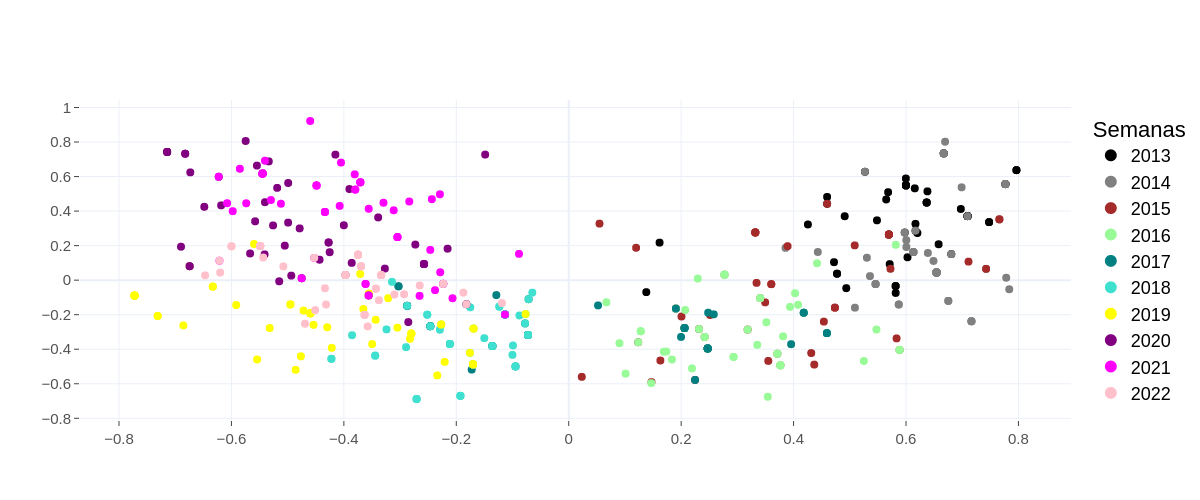

In [69]:
fig = go.Figure()
MCA_plot('row',dc,df)
fig.update_layout(template='plotly_white', title="")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

### Granger Causality GC

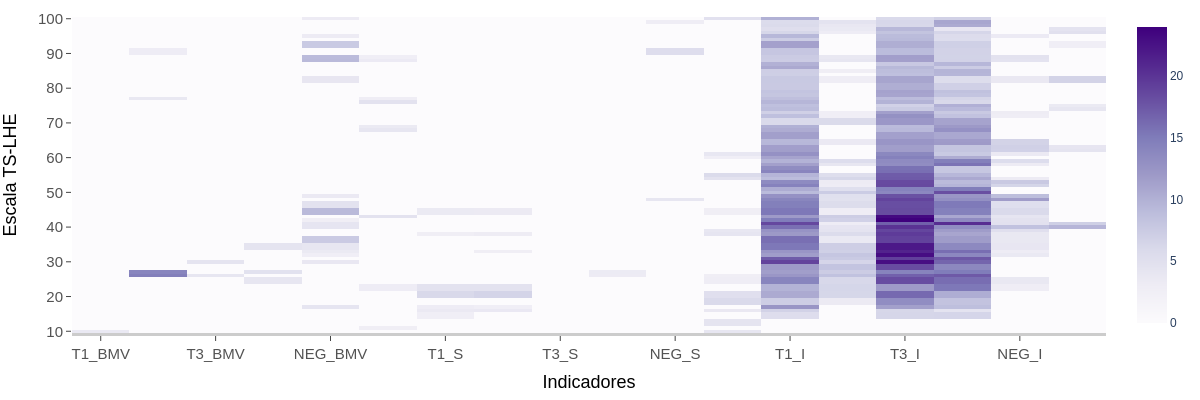

In [70]:
fig = px.imshow(M_coef_2,x=col_names,color_continuous_scale='Purples', origin='lower',
                y=list(np.arange(10,10+H_matrix.shape[0])))
config_fig('Escala TS-LHE','Indicadores')
fig.show(renderer="png")

In [71]:
fig = go.Figure()
Hurst_kweek(np.argmax(np.mean(M_coef_2,axis=1)))
fig.update_layout(legend=dict(orientation="v",entrywidth=300,yanchor="bottom",y=0.0, xanchor="right",x=0.95,
                                font=dict(size=18,color="black"),))
fig.update_layout(showlegend=True)
fig.show()

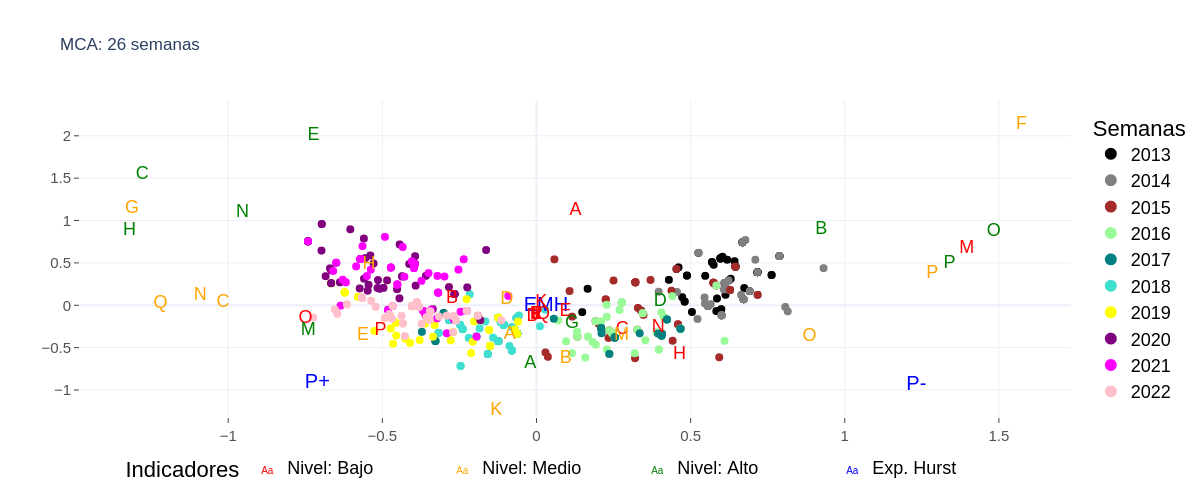

In [72]:
k_vecinos = np.argmax(np.mean(M_coef_2,axis=1))
dc, df = MCA_score(type_token,type_size,k_vecinos)
fig = go.Figure()
MCA_plot('row',dc,df)
MCA_plot('col',dc,df)

fig.update_layout(template='plotly_white', title="MCA: "+str(10+k_vecinos)+" semanas")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

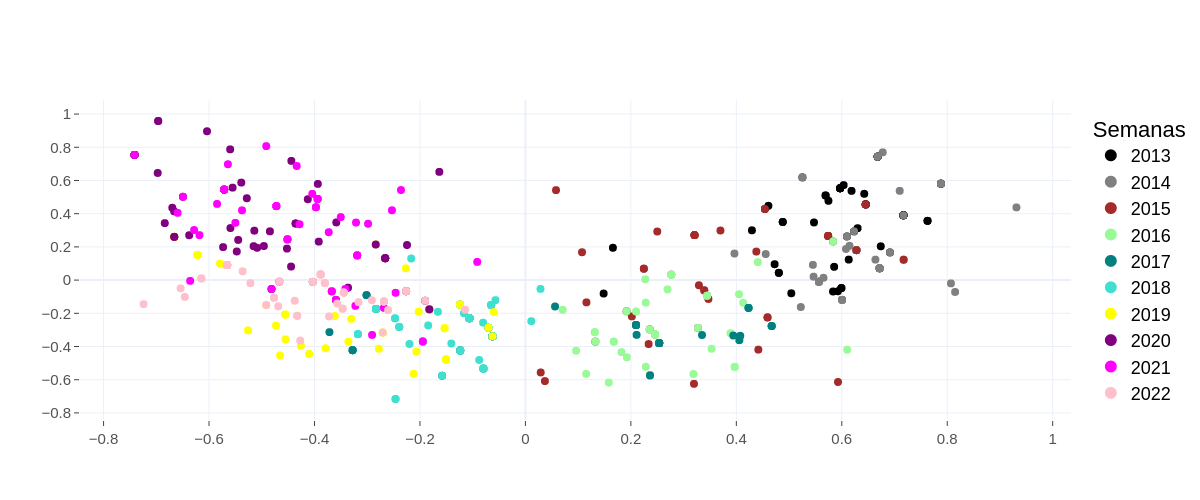

In [73]:
fig = go.Figure()
MCA_plot('row',dc,df)
fig.update_layout(template='plotly_white', title="")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

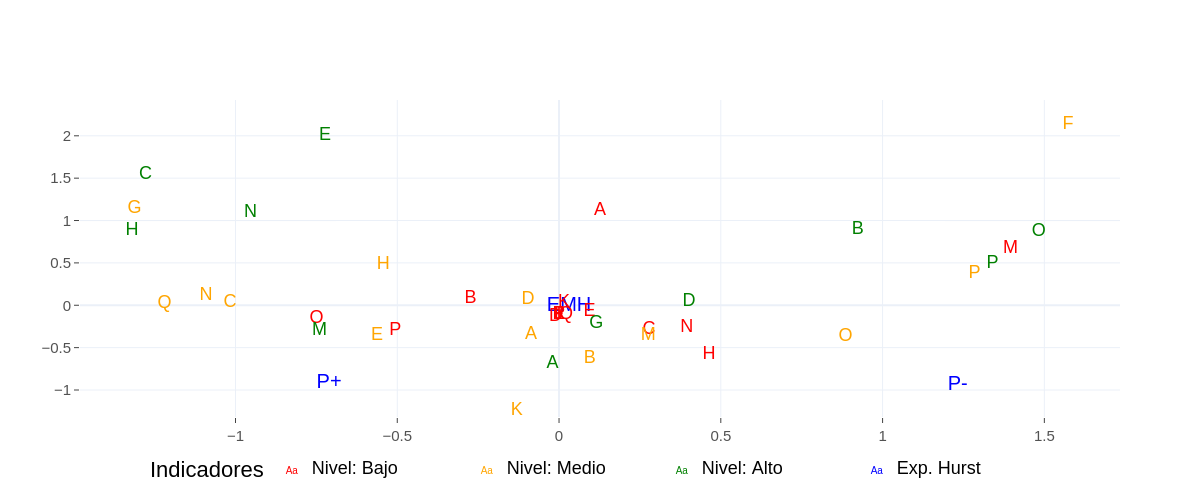

In [74]:
fig = go.Figure()
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title="")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

### Entropia entre muestras

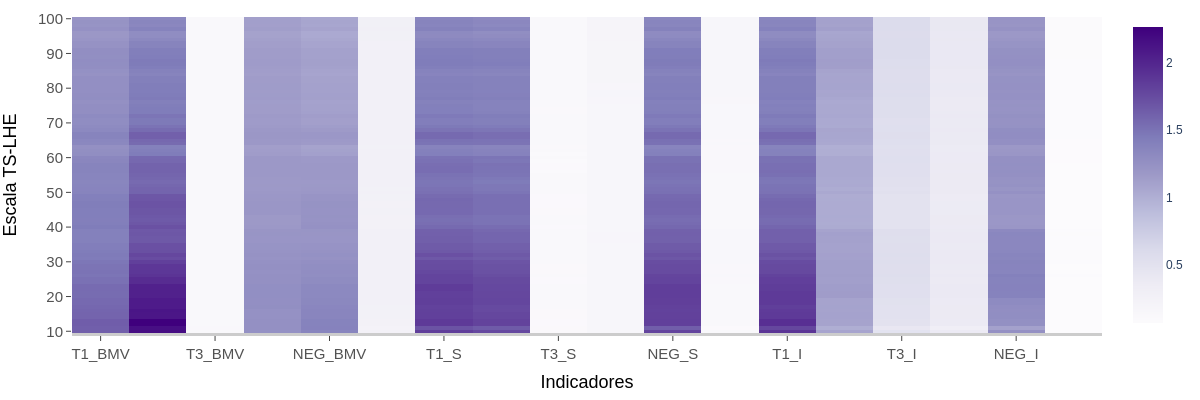

In [75]:
fig = px.imshow(M_coef_3,x=col_names,color_continuous_scale='Purples', origin='lower',
                y=list(np.arange(10,10+H_matrix.shape[0])),)
config_fig('Escala TS-LHE','Indicadores')
fig.show(renderer="png")

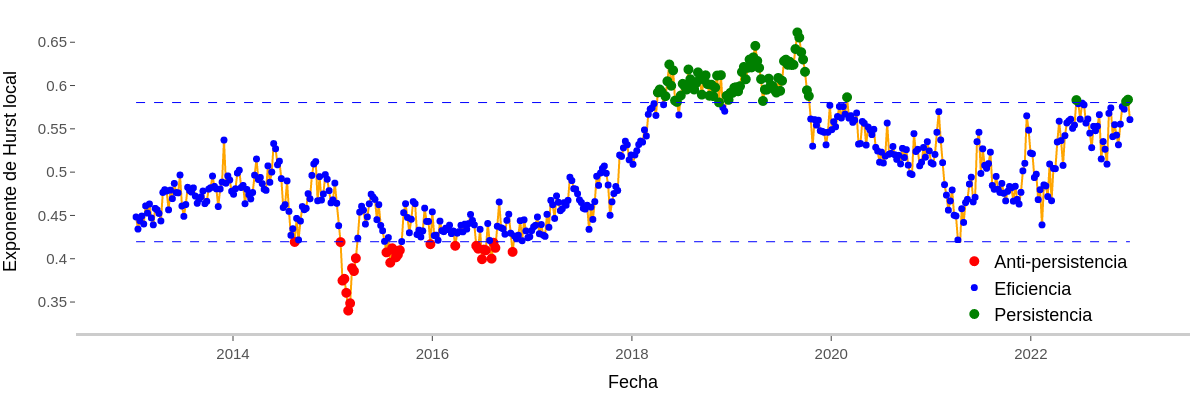

In [76]:
fig = go.Figure()
Hurst_kweek(np.argmin(np.mean(M_coef_3,axis=1)))
fig.update_layout(legend=dict(orientation="v",entrywidth=300,yanchor="bottom",y=0.0, xanchor="right",x=0.95,
                                font=dict(size=18,color="black"),))
fig.update_layout(showlegend=True)
fig.show(renderer="png")

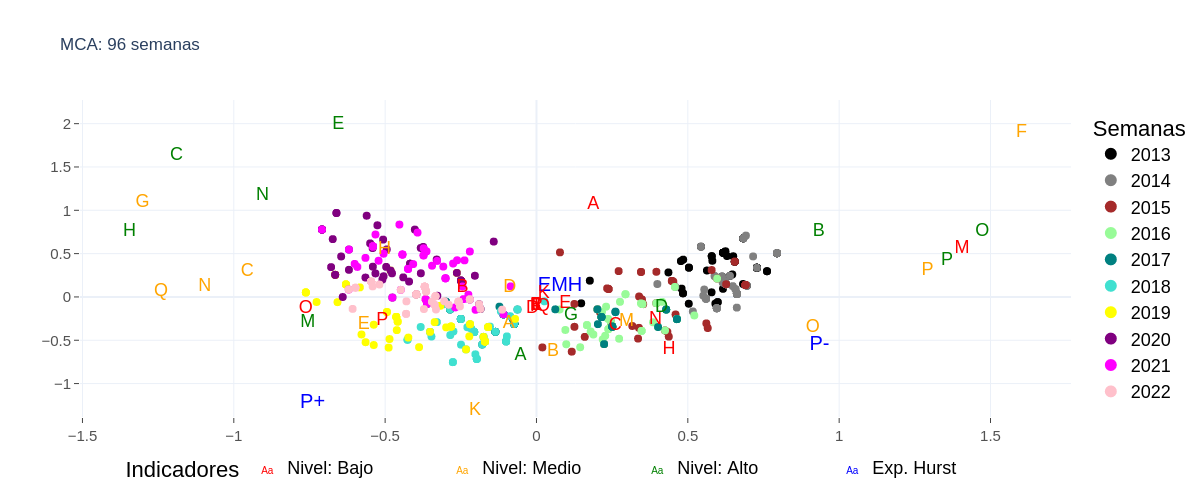

In [77]:
k_vecinos = np.argmin(np.mean(M_coef_3,axis=1))
dc, df = MCA_score(type_token,type_size,k_vecinos)
fig = go.Figure()
MCA_plot('row',dc,df)
MCA_plot('col',dc,df)

fig.update_layout(template='plotly_white', title="MCA: "+str(10+k_vecinos)+" semanas")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

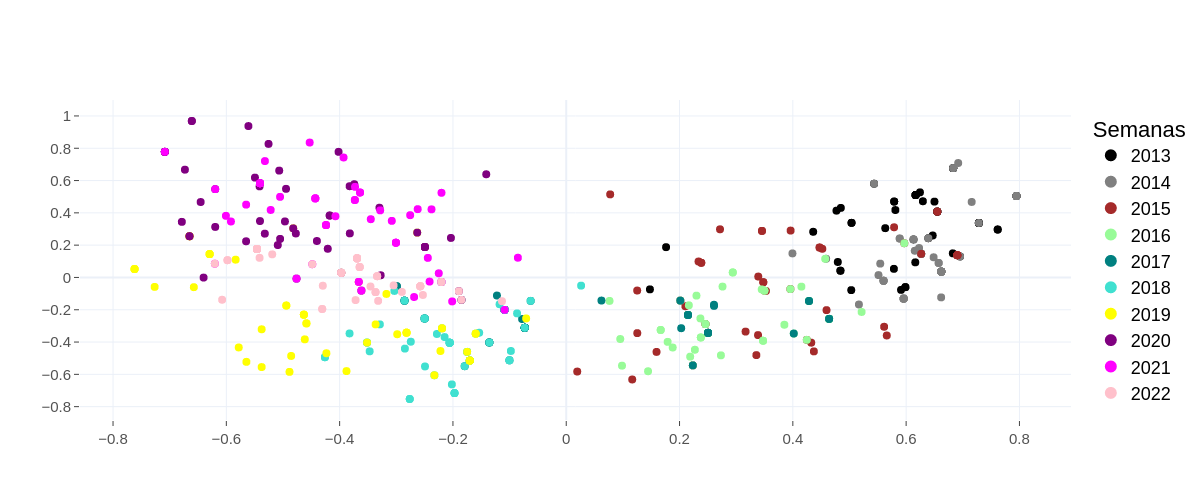

In [78]:
fig = go.Figure()
MCA_plot('row',dc,df)
fig.update_layout(template='plotly_white', title="")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

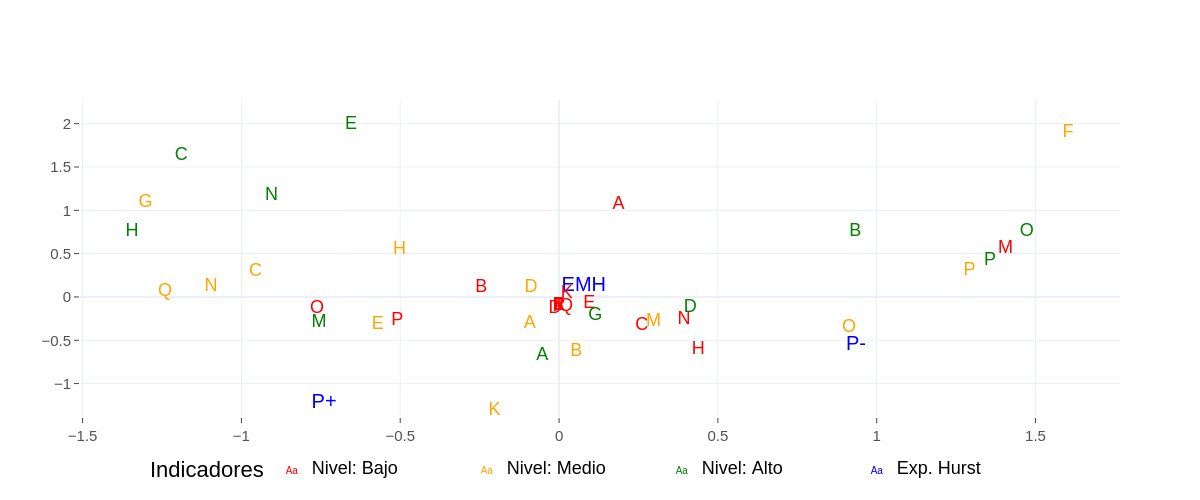

In [79]:
fig = go.Figure()
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title="")
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

## MAX-MIN

In [80]:
with open(path+ "Matrix_hurst.pickle", "rb") as fp:
    H_matrix = pickle.load(fp)

with open(path+ "Matrix_mx_mean.pickle", "rb") as fp:
    Ts_mx = pickle.load(fp)
with open(path+ "Index_mx_mean.pickle", "rb") as fp:
    Index_mxmn = pickle.load(fp)
M2_coef_1 = Ts_mx[0]
M2_coef_2 = Ts_mx[1]
M2_coef_3 = Ts_mx[2]

In [81]:
type_token = 'mean'
type_size = 'mx'
dim = ['x','y']

In [82]:
col_names = []
for i in Index_mxmn.columns:
  col_names.append(i.replace('3', '4').replace('2', '3').replace('1', '2').replace('0', '1'))

### DTW

In [83]:
fig = px.imshow(M2_coef_1,x=col_names,color_continuous_scale='Purples', origin='lower')
config_fig('Escala TS-LHE','Indicadores')
fig.show()

In [84]:
fig = go.Figure()
Hurst_kweek(np.argmax(np.mean(M2_coef_1,axis=1)))
fig.update_layout(legend=dict(orientation="v",entrywidth=300,yanchor="bottom",y=0.0, xanchor="right",x=0.95,
                                font=dict(size=18,color="black"),))
fig.update_layout(showlegend=True)
fig.show()

In [85]:
k_vecinos = np.argmax(np.mean(M2_coef_1,axis=1))
dc, df = MCA_score(type_token,type_size,k_vecinos)

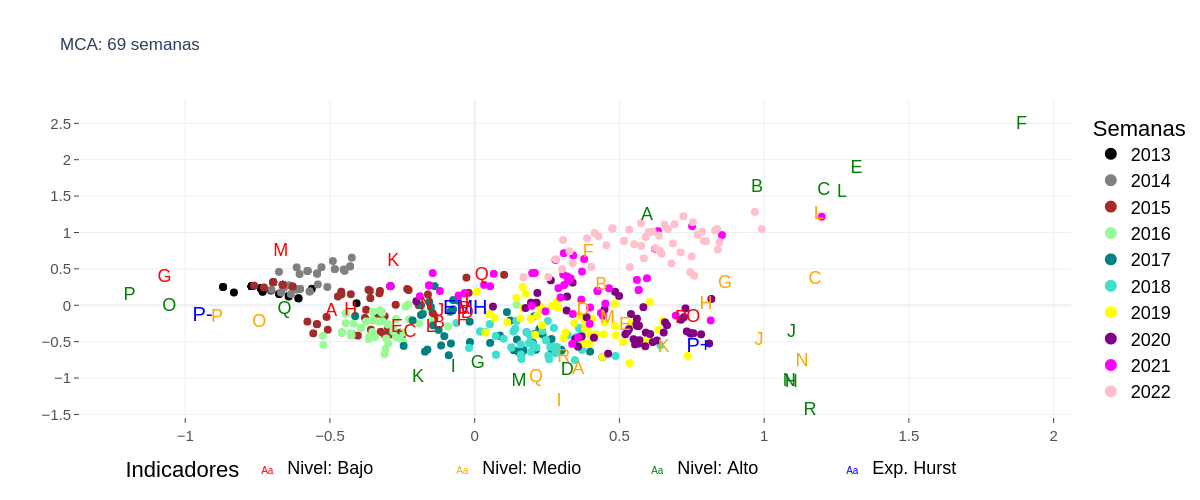

In [86]:
fig = go.Figure()
MCA_plot('row',dc,df)
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title="MCA: "+str(10+k_vecinos)+' semanas')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

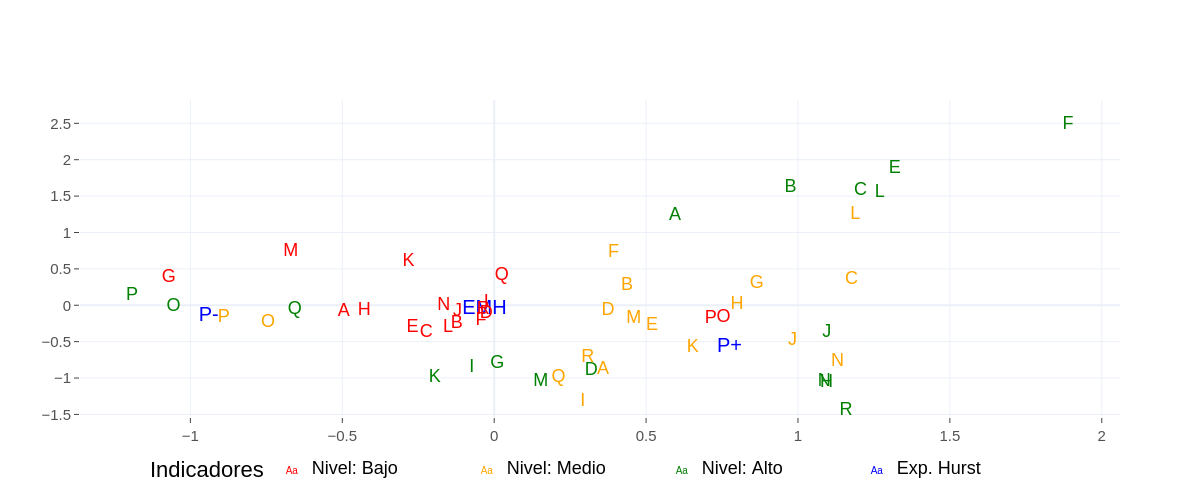

In [87]:
fig = go.Figure()
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title='')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

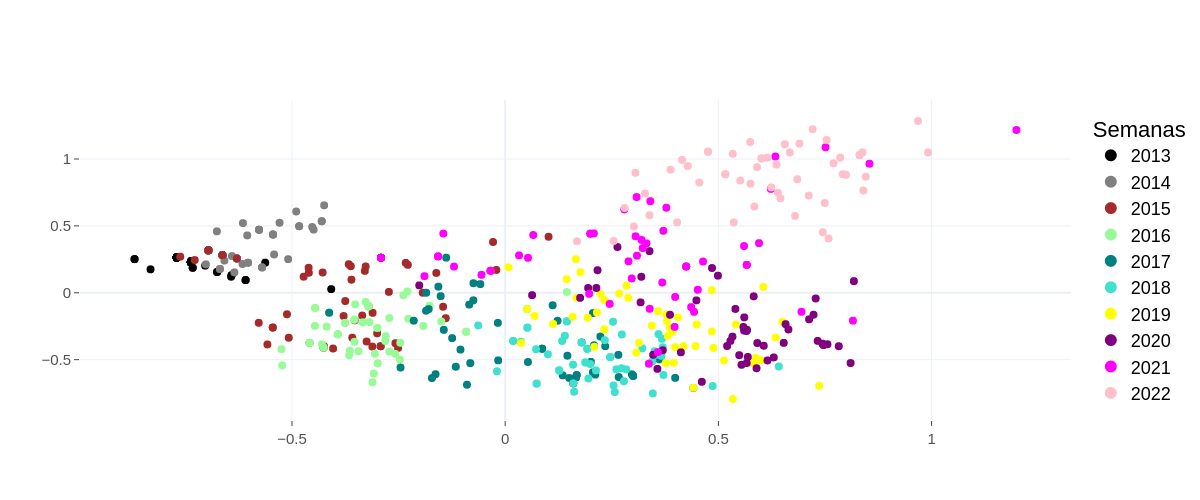

In [88]:
fig = go.Figure()
MCA_plot('row',dc,df)
fig.update_layout(template='plotly_white', title='')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

### Granger Causality

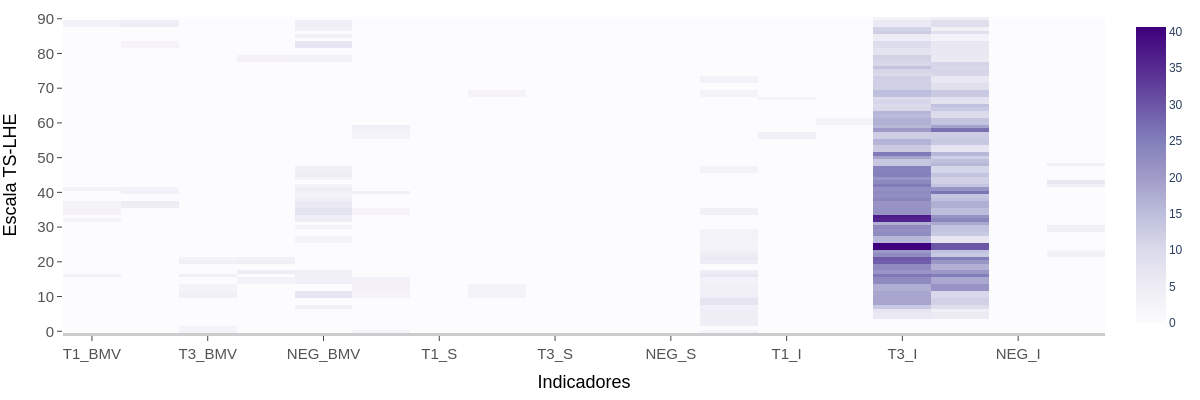

In [89]:
fig = px.imshow(M2_coef_2,x=col_names,color_continuous_scale='Purples', origin='lower')
config_fig('Escala TS-LHE','Indicadores')
fig.show(renderer="png")

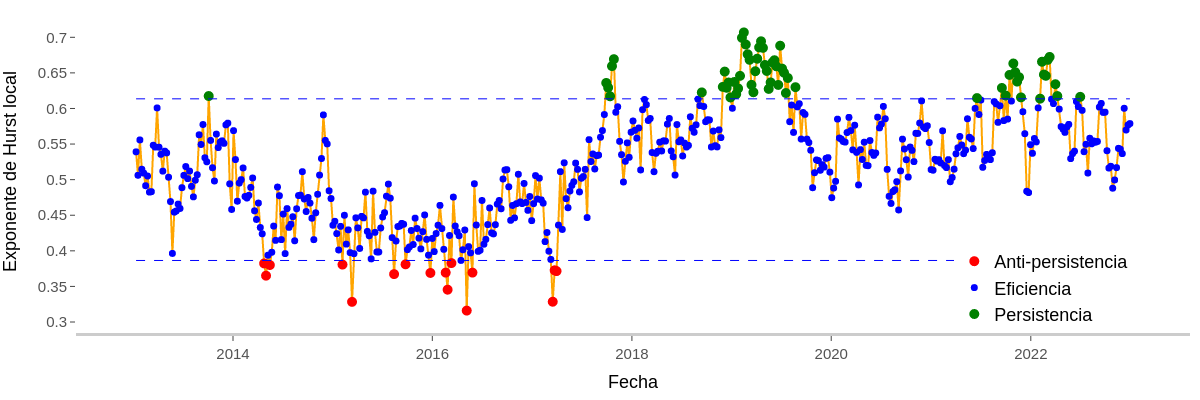

In [90]:
fig = go.Figure()
Hurst_kweek(np.argmax(np.mean(M2_coef_2,axis=1)))
fig.update_layout(legend=dict(orientation="v",entrywidth=300,yanchor="bottom",y=0.0, xanchor="right",x=0.95,
                                font=dict(size=18,color="black"),))
fig.update_layout(showlegend=True)
fig.show(renderer="png")

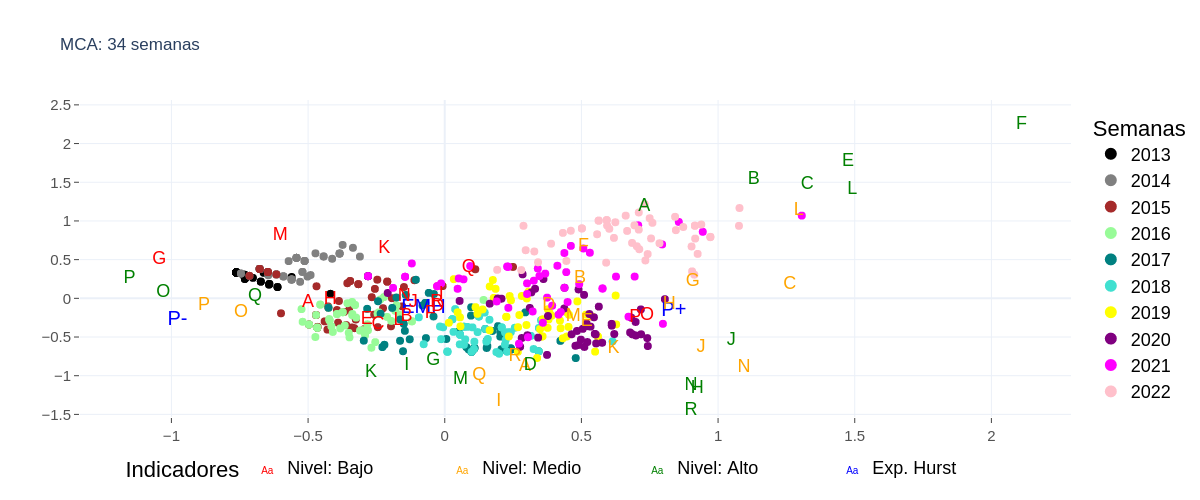

In [91]:
k_vecinos = np.argmax(np.mean(M2_coef_2,axis=1))
dc, df = MCA_score(type_token,type_size,k_vecinos)
fig = go.Figure()
MCA_plot('row',dc,df)
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title="MCA: "+str(10+k_vecinos)+' semanas')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

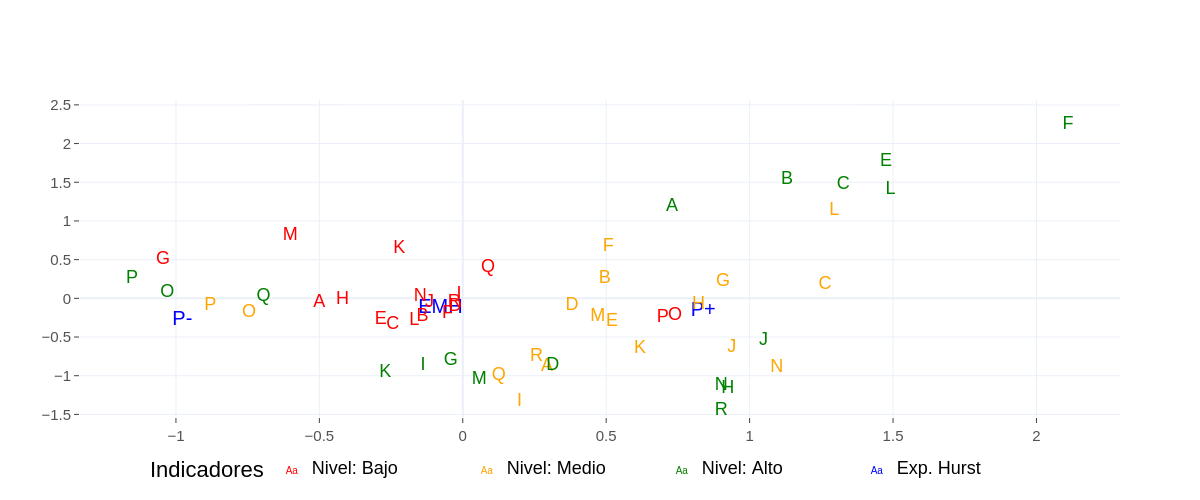

In [92]:
fig = go.Figure()
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title='')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

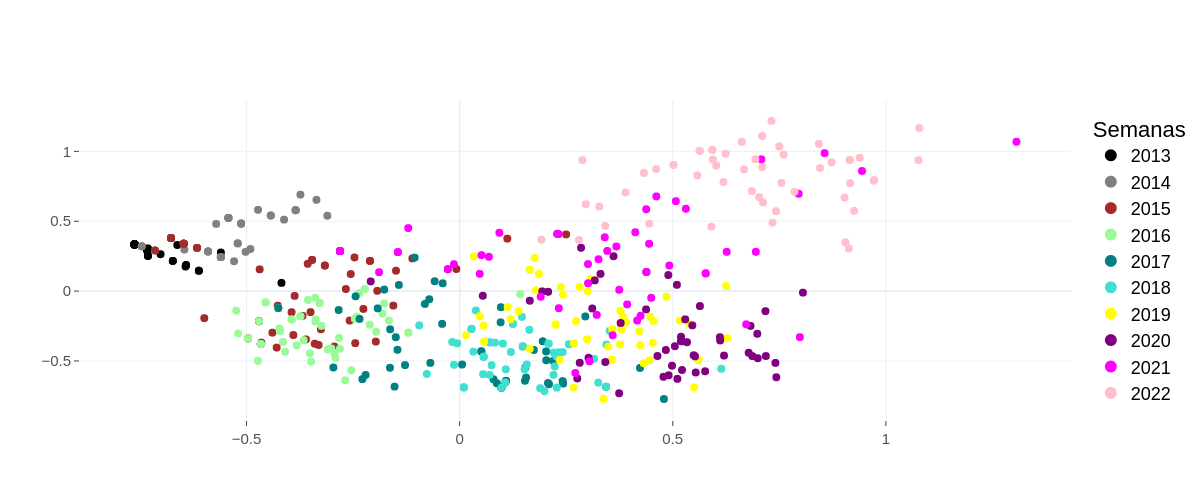

In [93]:
fig = go.Figure()
MCA_plot('row',dc,df)
fig.update_layout(template='plotly_white', title='')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

### Entropia

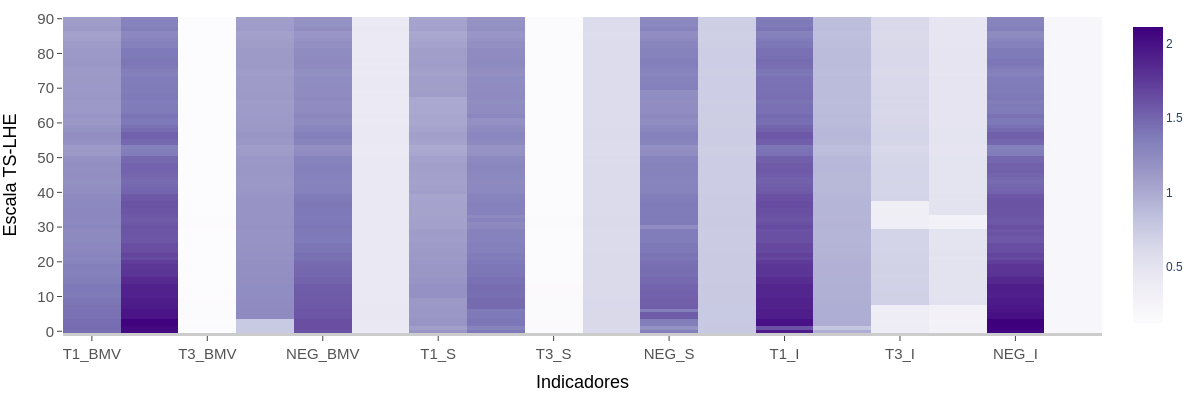

In [94]:
fig = px.imshow(M2_coef_3,x=col_names,color_continuous_scale='Purples', origin='lower')
config_fig('Escala TS-LHE','Indicadores')
fig.show(renderer="png")

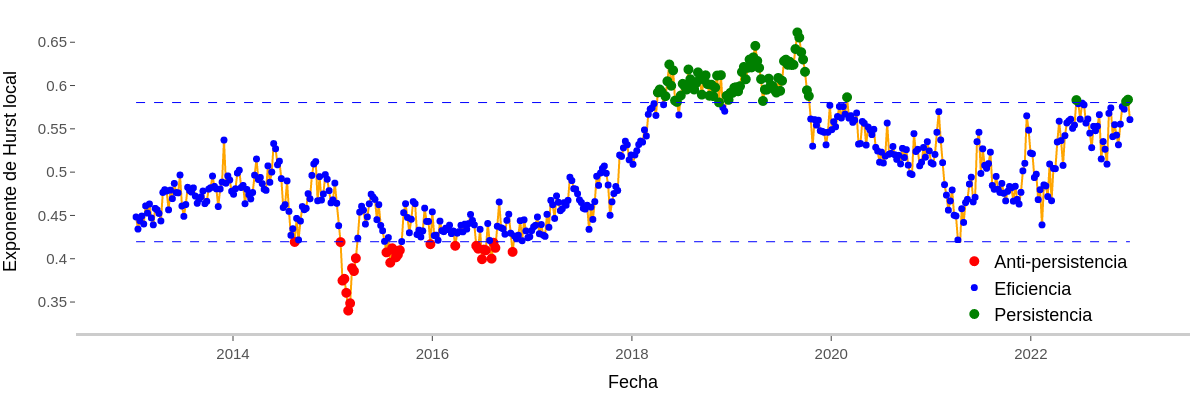

In [95]:
fig = go.Figure()
Hurst_kweek(np.argmin(np.mean(M2_coef_3,axis=1)))
fig.update_layout(legend=dict(orientation="v",entrywidth=300,yanchor="bottom",y=0.0, xanchor="right",x=0.95,
                                font=dict(size=18,color="black"),))
fig.update_layout(showlegend=True)
fig.show(renderer="png")

In [96]:
k_vecinos = np.argmin(np.mean(M2_coef_3,axis=1))
dc, df = MCA_score(type_token,type_size,k_vecinos)

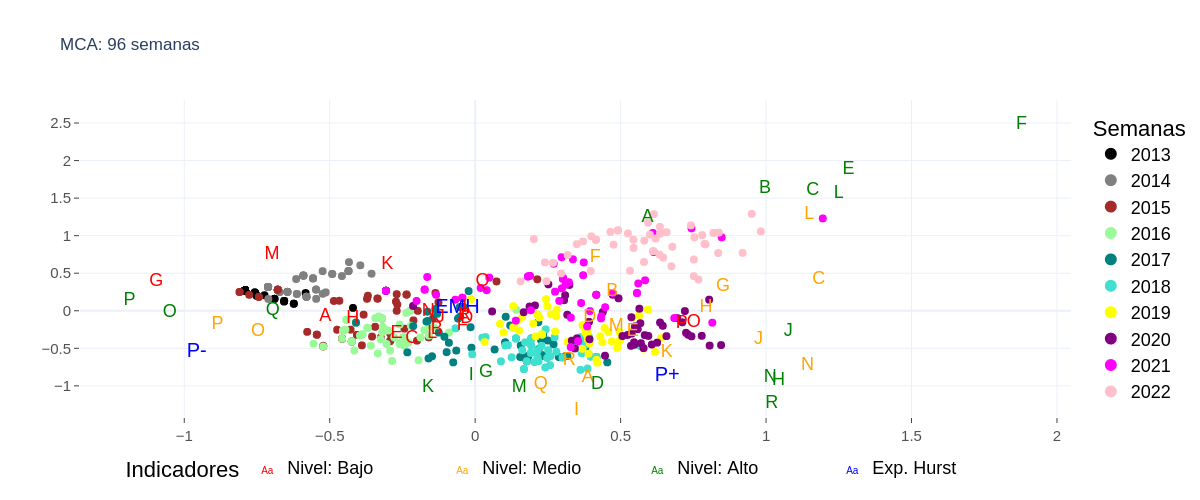

In [97]:
fig = go.Figure()
MCA_plot('row',dc,df)
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title="MCA: "+str(10+k_vecinos)+' semanas')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

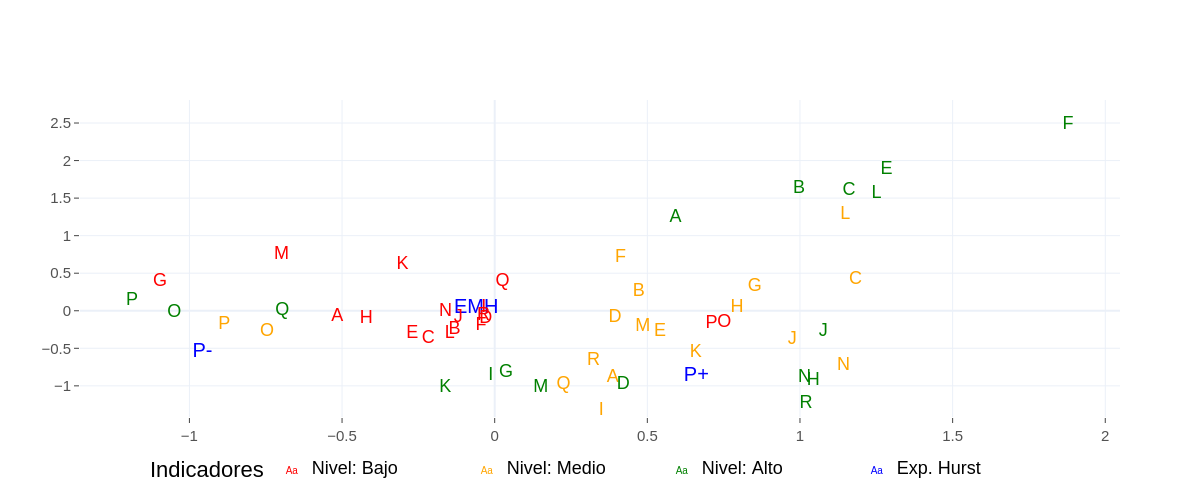

In [98]:
fig = go.Figure()
MCA_plot('col',dc,df)
fig.update_layout(template='plotly_white', title='')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")

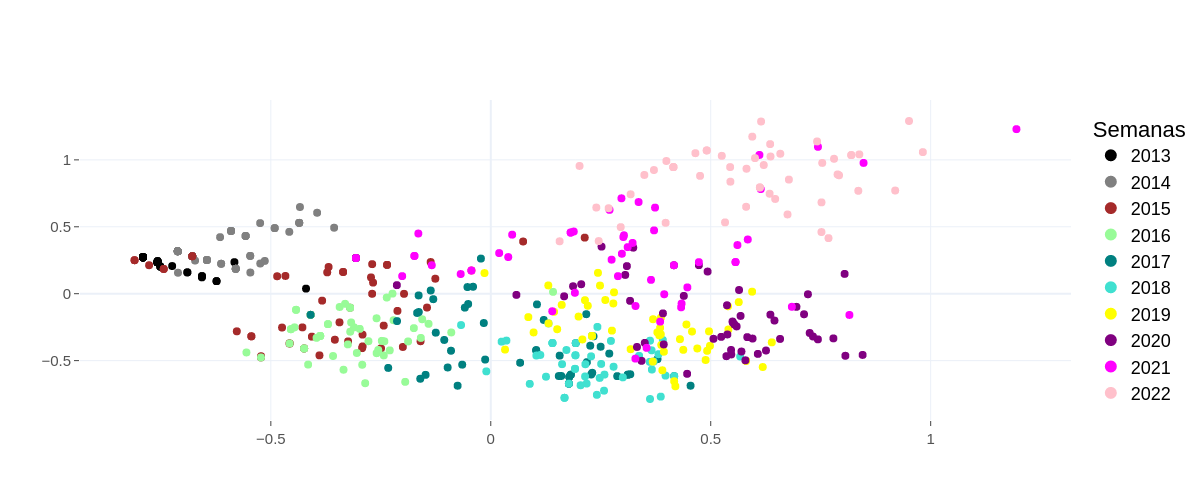

In [99]:
fig = go.Figure()
MCA_plot('row',dc,df)
fig.update_layout(template='plotly_white', title='')
fig.update_layout(width=1200,height=500)
fig.show(renderer="png")